In [2]:
import pandas as pd
import numpy as np
import numba as nb
from itertools import product

from timeit import default_timer as timer

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
%cd gdrive/MyDrive/

/content/gdrive/MyDrive


### PFound

Исходные данные - Yandex Cup 2022 Analytics

- Ссылка - https://yandex.ru/cup/analytics/analysis/ , пример A. Рассчитать 
- Данные - https://yadi.sk/d/guqki4UI4hFlXQ


Формула

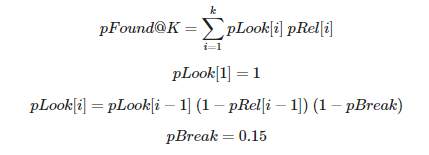

In [ ]:
qid_query = pd.read_csv("qid_query.tsv", sep="\t", names=["qid", "query"])
qid_url_rating = pd.read_csv("qid_url_rating.tsv", sep="\t", names=["qid", "url", "rating"])
hostid_url = pd.read_csv("hostid_url.tsv", sep="\t", names=["hostid", "url"])

# делаем join двух таблиц, чтобы было просто брать url с максимальным рейтингом
qid_url_rating_hostid = pd.merge(qid_url_rating, hostid_url, on="url")

#### Yandex implementation

In [ ]:
def plook(ind, rels):
    if ind == 0:
        return 1
    return plook(ind - 1, rels) * (1 - rels[ind - 1]) * (1 - 0.15)


def pfound(group):
    max_by_host = group.groupby("hostid")["rating"].max()  # максимальный рейтинг хоста
    top10 = max_by_host.sort_values(ascending=False)[:10]  # берем топ10 урлов с наивысшим рейтингом
    res = 0
    for ind, val in enumerate(top10):
        res += val * plook(ind, top10.values)
    return res

start = timer()
qid_pfound = qid_url_rating_hostid.groupby('qid').apply(pfound)
end = timer()
print(end - start, end='\n\n')
qid_pfound

0.024655209999764338



qid
5308      0.415820
48815     0.655448
49587     0.493599
55082     0.497771
58989     0.497771
60304     0.735836
63179     0.460028
70357     0.655448
70618     0.263596
79514     0.764755
91889     0.344494
99543     0.772245
402111    0.324649
405851    0.718072
407522    0.460028
409073    0.808643
438518    0.497771
690263    0.770353
692059    0.655448
692308    0.852628
dtype: float64

#### Vectorized implementation

In [ ]:
qid_url_rating_hostid.head()

,qid,url,rating,hostid
0,402111,http://24-job.com/board/job_australia/232-1-2-...,0.07,7
1,402111,http://24-job.com/board/job_australia/232-1-2-...,0.07,7
2,402111,http://802351.info/5964-v-avstralii.html,0.00,13
3,402111,http://auscommunity.com/blog/jobs/,0.00,53
4,402111,http://auscommunity.com/tag/%D1%84%D0%BE%D1%82...,0.00,53


In [ ]:
def vectorized_pfound(data, p_break=0.15, k=10):
  top_k_for_qid = data.groupby(['qid', 'hostid'])['rating'].max().reset_index().groupby('qid')['rating'].nlargest(k).reset_index().drop('level_1', axis=1)

  top_k_for_qid['rank'] = top_k_for_qid.groupby('qid').cumcount() + 1

  top_k_for_qid['1-pRel'] = (1 - top_k_for_qid['rating']).shift(1)
  top_k_for_qid['1-pBreak'] = 1 - p_break
  top_k_for_qid.loc[top_k_for_qid['rank'] == 1, '1-pRel'] = 1
  top_k_for_qid.loc[top_k_for_qid['rank'] == 1, '1-pBreak'] = 1

  top_k_for_qid['coef'] = top_k_for_qid['1-pBreak'] * top_k_for_qid['1-pRel']
  top_k_for_qid['pLook'] = top_k_for_qid.groupby('qid')['coef'].cumprod()
  top_k_for_qid['mult'] = top_k_for_qid['pLook'] * top_k_for_qid['rating'] 
  return top_k_for_qid.groupby('qid').sum()['mult']

In [ ]:
start = timer()
res = vectorized_pfound(qid_url_rating_hostid)
end = timer()
print(end - start, end='\n\n')
res

0.02788820499972644



qid
5308      0.415820
48815     0.655448
49587     0.493599
55082     0.497771
58989     0.497771
60304     0.735836
63179     0.460028
70357     0.655448
70618     0.263596
79514     0.764755
91889     0.344494
99543     0.772245
402111    0.324649
405851    0.718072
407522    0.460028
409073    0.808643
438518    0.497771
690263    0.770353
692059    0.655448
692308    0.852628
Name: mult, dtype: float64

### MRR - Mean Reciprocal Rank

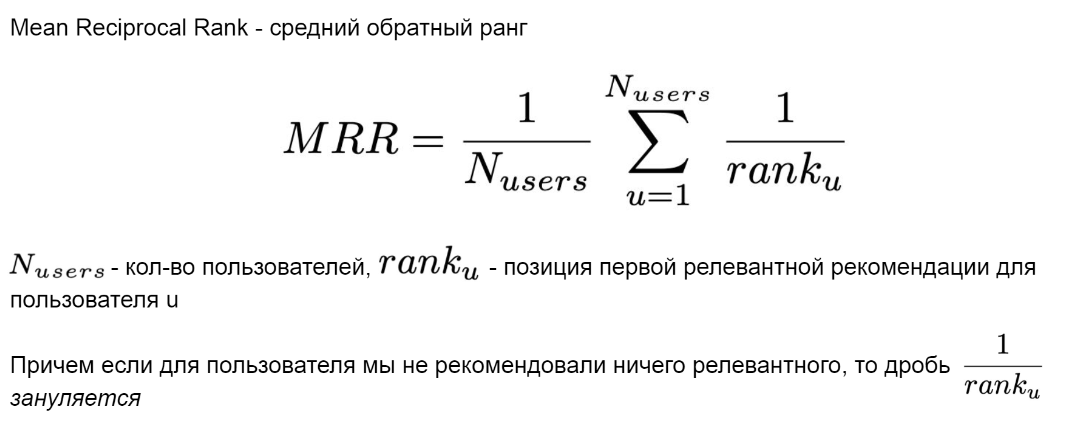

In [ ]:
interactions = pd.read_csv('interactions.csv')

interactions.rename(
    columns={
        'track_id': 'item_id',
        'last_watch_dt': 'date',
        'total_dur': 'weight'
    }, 
    inplace=True) 

interactions['date'] = pd.to_datetime(interactions['date'])
users = pd.read_csv('users.csv')
items = pd.read_csv('items.csv')

In [ ]:
def get_df(n_users, top_k):
  sample_users = np.random.choice(interactions['user_id'].unique(), n_users)
  df = interactions[interactions['user_id'].isin(sample_users)].reset_index(drop=True)
  recs = np.random.choice(df['item_id'], size=(n_users, top_k))
  return sample_users, df.drop(['date', 'weight', 'watched_pct'], axis=1).values, recs

#### Naive version

In [ ]:
def naive_mrr(users, target, recs):
  res = []
  for i, user in enumerate(users):
    current_target = target[target[:, 0] == user][:, 1]
    user_rank = 0
    for j, rec in enumerate(recs):
      if j in current_target:
        user_rank = 1 / (j + 1)
        break
      res.append(user_rank)
  return np.array(res).mean()

In [ ]:
naive_mrr(*get_df(10, 10))

0.0

#### Numba version

In [ ]:
@nb.njit(cache=True, parallel=True)
def numba_mrr(users, target, recs):
  res = np.zeros(len(users))
  for i in nb.prange(len(users)):
    user = users[i]
    user_target = target[target[:, 0] == user][:, 1]
    user_rank = 0
    for j, rec in enumerate(recs[i]):
      if rec in user_target:
        user_rank = 1 / (j + 1)
        res[i] = user_rank
  return res.mean()

In [ ]:
numba_mrr(*get_df(10, 10))

0.12027777777777778

#### Pandas version

In [ ]:
def pandas_mrr(users, target, recs):
  df_recs = pd.DataFrame({
          'user_id': np.repeat(users, recs.shape[0]),
          'item_id': recs.ravel()
  })
  df_recs['rank'] = df_recs.groupby('user_id').cumcount() + 1
  df_recs = target.merge(df_recs, how='left', left_on=['user_id', 'item_id'], right_on=['user_id', 'item_id'])
  
  first_ranks = df_recs.groupby('user_id').first()
  first_ranks['mrr'] = 1 / first_ranks['rank']
  first_ranks['mrr'] = first_ranks['mrr'].fillna(0)
  return first_ranks['mrr'].mean()

In [ ]:
users, target, recs = get_df(10, 10)
target = pd.DataFrame(target, columns=['user_id', 'item_id'])
pandas_mrr(users, target, recs)

0.2277777777777778

#### Comparison

In [ ]:
users_count = [100, 1000, 10000, 100000]
top_k = [10, 50, 100]
res = []

for u_count, k in list(product(users_count, top_k)):
  for algo in [naive_mrr, numba_mrr, pandas_mrr]:
    algo_name =  algo.__name__
    if algo.__name__ == 'pandas_mrr':
      users, target, recs = get_df(10, 10)
      target = pd.DataFrame(target, columns=['user_id', 'item_id'])
      start = timer()
      pandas_mrr(users, target, recs)
      end = timer()
    else:
      start = timer()
      algo(*get_df(10, 10))
      end = timer()
    res.append({
        'top_k': k,
        'users_count': u_count,
        'algo': algo_name,
        'time': end - start
    })

res = pd.DataFrame(res)

In [ ]:
res.head()

,top_k,users_count,algo,time
0,10,100,naive_mrr,1.796344
1,10,100,numba_mrr,3.089606
2,10,100,pandas_mrr,0.007727
3,50,100,naive_mrr,0.283906
4,50,100,numba_mrr,0.288884


In [ ]:
res['log_time'] = np.log(res['time'])

In [ ]:
sns.axes_style('whitegrid');

In [ ]:
def plot(need_log=False, y_lim=(0, 0.4)):
  time_col = 'log_time' if need_log else 'time'
  g = sns.FacetGrid(res, col="top_k", hue='algo')
  g.figure.set_size_inches(15, 4)
  g.map(sns.lineplot, "users_count", time_col, marker="o")
  g.set(ylim=y_lim)
  g.add_legend();

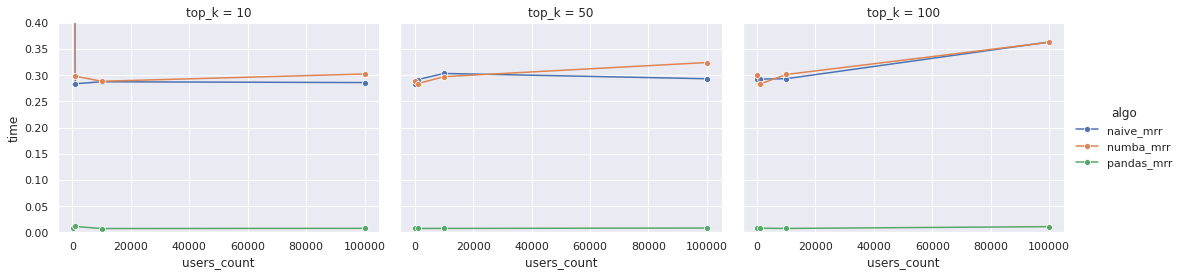

In [ ]:
plot()

### UsersKFoldLeavePOut validation

In [15]:
data = []

with open('train', 'r') as f:
   for i, line in enumerate(f.readlines()[:100000]):
     for item_id in line.split():
        item_id = int(item_id)
        data.append({
            'user_id': i,
            'item_id': item_id
        })

In [17]:
data = pd.DataFrame(data, columns = ['user_id', 'item_id'])
data.head()

,user_id,item_id
0,0,333396
1,0,267089
2,0,155959
3,0,353335
4,0,414000


In [26]:
class UsersKFoldPOut():
    def __init__(self, n_folds, p, random_seed=23, user_column='user_id'):
        self.n_folds = n_folds
        self.random_seed = random_seed
        self.user_column = user_column 
        self.p = p
    
    def split(self, df):
        users = df[self.user_column].unique()
        users_count = len(users)
        
        np.random.seed(self.random_seed)
        np.random.shuffle(users)
        
        fold_sizes = np.full(self.n_folds, users_count // self.n_folds, dtype=int)
        fold_sizes[: users_count % self.n_folds] += 1
        current = 0
        like_order = df.groupby(self.user_column).cumcount()
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            test_fold_users = users[start:stop]
            test_mask = df[self.user_column].isin(test_fold_users) & (like_order < self.p)
            train_mask = ~df[self.user_column].isin(test_fold_users)
            
            yield train_mask, test_mask

In [36]:
p = 5
cv = UsersKFoldPOut(n_folds=3, p=p)

for i, (train_mask, test_mask) in enumerate(cv.split(data)):
    train = data[train_mask]
    test = data[test_mask]
    print(f'Fold#{i} | Train: {train.shape[0]}, Test: {test.shape[0]}')

    assert len(set(train['user_id'].unique()).intersection(test['user_id'].unique())) == 0, 'Train and test intersect'
    assert test.groupby('user_id').count().max()[0] <= p, 'Test part has more than p items'

Fold#0 | Train: 5427560, Test: 166670
Fold#1 | Train: 5427571, Test: 166665
Fold#2 | Train: 5427571, Test: 166665
